<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/pytoch_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pytoch_lstm__삼성전자 주가예측

## 데이터 로드

In [ ]:
!pip install pandas_datareader

In [ ]:
!pip install finance-datareader

In [8]:
import numpy as np 
import pandas as pd 
# import pandas_datareader.data as pdr 
import matplotlib.pyplot as plt 
import datetime 
import torch 
import torch.nn as nn 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader


In [9]:
# 주식가격 로딩
import FinanceDataReader as fdr

start_date = '20180101'
end_date = datetime.datetime.now().strftime("%Y%m%d")
sample_code = '005930'
stock = fdr.DataReader( sample_code, start = start_date, end = end_date )
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177
2018-01-03,52540,52560,51420,51620,200270,0.011760
2018-01-04,52120,52180,50640,51080,233909,-0.010461
2018-01-05,51300,52120,51200,52120,189623,0.020360
2018-01-08,52400,52520,51500,52020,167673,-0.001919


In [12]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-09-01,76700,77100,75900,76800,16114775,0.001304
2021-09-02,76800,76800,75700,76000,15347486,-0.010417
2021-09-03,76400,76700,76000,76600,12096419,0.007895
2021-09-06,76800,77600,76600,77300,12861180,0.009138
2021-09-07,77100,77100,76000,76200,6908876,-0.014230


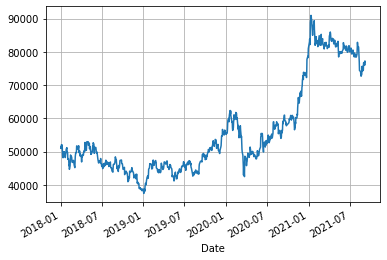

In [11]:
stock.Close.plot(grid=True)

## 데이터 전처리

In [15]:
# 거래량 제외
X = stock.drop(columns='Volume') 
y = stock.iloc[:, 4:5] 
print(X) 
print(y)

             Open   High    Low  Close    Change
Date                                            
2018-01-02  51380  51400  50780  51020  0.001177
2018-01-03  52540  52560  51420  51620  0.011760
2018-01-04  52120  52180  50640  51080 -0.010461
2018-01-05  51300  52120  51200  52120  0.020360
2018-01-08  52400  52520  51500  52020 -0.001919
...           ...    ...    ...    ...       ...
2021-09-01  76700  77100  75900  76800  0.001304
2021-09-02  76800  76800  75700  76000 -0.010417
2021-09-03  76400  76700  76000  76600  0.007895
2021-09-06  76800  77600  76600  77300  0.009138
2021-09-07  77100  77100  76000  76200 -0.014230

[909 rows x 5 columns]
              Volume
Date                
2018-01-02    169485
2018-01-03    200270
2018-01-04    233909
2018-01-05    189623
2018-01-08    167673
...              ...
2021-09-01  16114775
2021-09-02  15347486
2021-09-03  12096419
2021-09-06  12861180
2021-09-07   6908876

[909 rows x 1 columns]


In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
mm = MinMaxScaler() 
ss = StandardScaler() 
X_ss = ss.fit_transform(X) 
y_mm = mm.fit_transform(y) 

# Train Data 
X_train = X_ss[:800, :] 
X_test = X_ss[800:, :]
 
# Test Data 
y_train = y_mm[:800, :] 
y_test = y_mm[800:, :] 

print("Training Shape", X_train.shape, y_train.shape) 
print("Testing Shape", X_test.shape, y_test.shape)


Training Shape (800, 5) (800, 1)
Testing Shape (109, 5) (109, 1)


In [19]:
# 학습할수 있는 형태로 변환 bath
X_train_tensors = Variable(torch.Tensor(X_train)) 
X_test_tensors = Variable(torch.Tensor(X_test)) 
y_train_tensors = Variable(torch.Tensor(y_train)) 
y_test_tensors = Variable(torch.Tensor(y_test)) 
X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1])) 
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 


print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape) 
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)


Training Shape torch.Size([800, 1, 5]) torch.Size([800, 1])
Testing Shape torch.Size([109, 1, 5]) torch.Size([109, 1])


In [20]:
# gpu확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 
print(torch.cuda.get_device_name(0))

Tesla K80


## lstm_layer 구성

In [21]:
class LSTM1(nn.Module): 
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length): 
    super(LSTM1, self).__init__() 
    self.num_classes = num_classes #number of classes 
    self.num_layers = num_layers #number of layers 
    self.input_size = input_size #input size 
    self.hidden_size = hidden_size #hidden state 
    self.seq_length = seq_length #sequence length 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm 
    self.fc_1 = nn.Linear(hidden_size, 128) #fully connected 1 
    self.fc = nn.Linear(128, num_classes) #fully connected last layer 
    self.relu = nn.ReLU() 
  
  def forward(self,x): 
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state 
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state 
    
    # Propagate input through LSTM 
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state 
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next 
    out = self.relu(hn) 
    out = self.fc_1(out) #first Dense 
    out = self.relu(out) #relu 
    out = self.fc(out) #Final Output return out

    return out

In [22]:
num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer


In [ ]:
for epoch in range(num_epochs): 
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass 
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0 
  
  # obtain the loss function 
  loss = loss_function(outputs, y_train_tensors.to(device)) 
  
  loss.backward() #calculates the loss of the loss function 
  
  optimizer.step() #improve from loss, i.e backprop 
  
  if epoch % 100 == 0: 
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


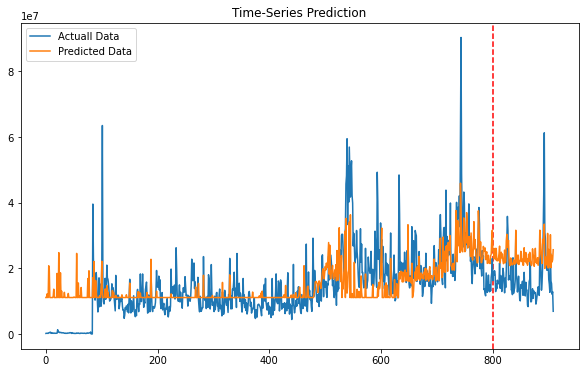

In [25]:
df_X_ss = ss.transform(stock.drop(columns='Volume'))
df_y_mm = mm.transform(stock.iloc[:, 4:5])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))

#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=800, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt